In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

data_folder = 'data'

Load data from parquet file

In [2]:
df = pd.read_parquet("tripdata_combined.parquet")

Preprocessing

In [3]:
# Keep relevant columns for regression
df = df[["trip_distance", "PULocationID", "passenger_count", "payment_type", "tip_amount", "time_of_day", "day_of_week", "season"]]

# Convert tip amount to whether or not customers tipped - consider tips lower than 25 cents as no tip
y =  (df['tip_amount'] > 0.25).astype(int).values

Setup model pipeline

In [4]:
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# One-hot encode categorical features and scale numerical features
preprocessor = ColumnTransformer([
    ('num', num_transformer, ['trip_distance']),
    ('cat', cat_transformer, ['passenger_count', 'PULocationID', 'payment_type', 'time_of_day', 'day_of_week', 'season']),
])

# Create linear regression model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(Cs=10, cv=5, scoring='accuracy', max_iter=1000, random_state=42))
])

Perform train-test split and train model

In [5]:
X = df.drop('tip_amount', axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# model.fit(X_train, y_train)

Load Pre-trained Model

In [8]:
with open("alex_rq1_model.pkl", "rb") as file:
    model = pickle.load(file)

Evaluate model

In [9]:
# Apply ReLU after model prediction to get rid of negative tip predictions
y_pred = model.predict(X_test)

Accuracy: 0.942774942198989
Precision: 0.9499714501843664
Recall: 0.9745293274974661
Confusion matrix:
[[1026511  181278]
 [  89967 3442213]]


Text(0.5, 1.0, 'Confusion Matrix')

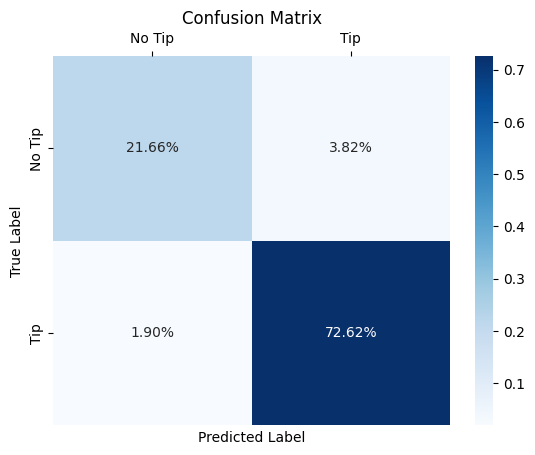

In [19]:
acc = np.dot(y_pred, y_test) / y_test.size
confmat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = np.ravel(confmat)
acc = (tp + tn) / y_test.size
precision = tp / (tp + fp)
recall = tp / (tp + fn) 

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion matrix:\n{confmat}")

# Plot Confusion Matrix

class_labels = ["No Tip", "Tip"]
ax = sns.heatmap(confmat / np.sum(confmat), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

ax.xaxis.tick_top()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

Save the Model

In [ ]:
# with open("alex_rq1_model.pkl", "wb") as file:
#     pickle.dump(model, file)